# MeerKAT Observations Metadata Analysis

##### Author: Sydil Kupa, (skupa@sarao.ac.za) and Rashaad Meyer (rmeyer@sarao.ac.za)



## Introduction
* The South African Radio Astronomy Observatory (SARAO) facilitates the radio astronomy initiatives within South Africa.
* MeerKAT is the name of the South African radio telescope
* Forms part of the African Very Long Baseline Network (AVN) with 8 African countries.
* Ghana is one of the AVN countries.
* SARAO has assisted Ghana turn a satellite dish into a radio dish
* Radio Astronomy is a field that studies celestrial objects at radio frequencies. We place telescopes in a radio quiet area and face them towards a celestrial object and wait to hear radio emmission from them.

![Radio Astronomy](https://www.mpg.de/15382707/original-1600249291.webp?t=eyJ3aWR0aCI6ODQ4LCJmaWxlX2V4dGVuc2lvbiI6IndlYnAiLCJxdWFsaXR5Ijo4Niwib2JqX2lkIjoxNTM4MjcwN30%3D--a7d06b47723707748060bd2f833e172694f61119)

## MeerKAT Data Life Cycle

Checkout a video of the data lifecycle: https://drive.google.com/file/d/1MUxA5aE8BPfV1OpVNzwgQfb4f3YXXhz3/view?usp=sharing

### Observational Metadata database : SOLR

Solr apache lucene is an open-source search platform that SARAO uses to to store metadata about observations data storage. To access Solr use http://kat-archive.kat.ac.za:8983/solr/kat_core

Solr provides
* full-text searching
* hit highlighting
* faceted search
* real-time indexing
* rich document handling.

The meatadata stored in Solr is of the observations that have been started by the operators throughtout to Archived. Idealy, we would like operators to start observing and the data should get to be archived. However, issues occur throughout the process that results in observations not being Archived.

Tasks To Do:

* A visual analysis of the distrubution of the issues will be investigated
* investigate factors that highly contritube to transfer status
* Create a prediction model to predict the status of an observation given different factors.

## Library Installations and Imports

In [ ]:
# Install required libriaries
%pip install requests
%pip install pandas
%pip install pysolr
%pip install matplotlib
%pip install seaborn
%pip install katdal
%pip install scikit-learn
%pip install xgboost

In [ ]:
# Import packages
import warnings
import pandas as pd
import requests
import urllib.request
import pysolr
import numpy as np
import json
import statistics
%matplotlib inline
import matplotlib.pyplot as plt
from IPython.display import JSON
from pandas import json_normalize


warnings.simplefilter('ignore')

### Glosarry

* 'id' - Identifier for an obs and its Unique. "1634550335-sdp-l1-flags"
* 'CaptureBlockId' - Unique and can produce more than one by product type
* 'CaptureStreamId' - The next 3 are used in data flagging
* 'CAS.ProductId' - 1634550335-sdp-l1-flags -l1 is for averaged data as opposed to high dumptime data
* 'CAS.ProductName' - Check if all three has the same name, then use one of them

* 'CAS.ProductTypeId' - Naming different products produced by an observation
* 'CAS.ProductTypeName'

* 'Prefix' - A prefic for flagging which is different for other products
* 'CAS.ProductTransferStatus' -
* 'size'- The size of the files in bytes
* 'num_objects' - The number of files associated with the blockID products
* 'ReferenceTapeStore' - Path to the tape storage
* 'ProductExpireTime' - Data ready to be archived
* 'ProposalId' - THe identifier for the proposal
* 'ProductArchivedTime' - The time the data was archieved.
* '_version_' - comparing same item for different versioning

## Exploratory Data Analysis of all the data

Understanding the dataset by visualising distributions, relationships and summary statistics.

#Product Type

In [ ]:
# Define the file path where you want to save the JSON file
product_types_file_path = 'product_types.json'

# Read the JSON file into a DataFrame
df_product_types = pd.read_json(product_types_file_path)
product_types_list = df_product_types.values.flatten().tolist()

# Display the DataFrame
meerkat_products = product_types_list[0::2]
count = product_types_list[1::2]
print(meerkat_products,list(count))



['urn:kat:FITSImageProduct', 'urn:kat:MeerKATReductionProduct', 'urn:kat:PlaceholderProduct', 'urn:kat:USEPTProduct', 'urn:kat:MeerKATFlagProduct', 'urn:kat:MeerKATVisibilityProduct', 'urn:kat:MeerKATTelescopeProduct', 'urn:kat:MeerKATAR1ReductionProduct', 'urn:kat:KatFile', 'urn:kat:MeerKATAR1TelescopeProduct', 'urn:kat:RTSReductionProduct', 'urn:kat:RTSTelescopeProduct', 'urn:kat:PTUSETimingArchiveProduct', 'urn:kat:MeerKATProposalId', 'urn:kat:MeerKATTelescopProduct', 'urn:kat:PulsarTimingArchiveProduct', 'urn:kat:PulsarSearchProduct', 'MeerKATVisibityProduct'] [15159239, 57209, 48658, 42411, 42232, 41753, 41391, 30521, 21848, 13779, 8105, 4569, 3192, 847, 355, 245, 132, 1]


In [ ]:
# What is the variation between number of product types
variance = statistics.variance(count)
variance

12731839476184.996

The variance between the frequencies is huge. Plotting them directly on a bar chart can make it difficult to visually compare the values. A number of strategies can be used to solve this

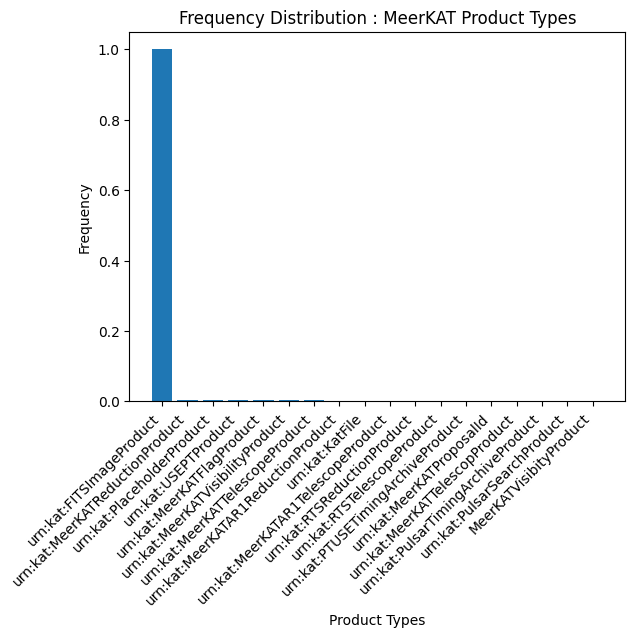

In [ ]:
# Normalize the frequencies using Min-Max normalization
min_freq = min(count)
max_freq = max(count)
normalized_frequencies = [(freq - min_freq) / (max_freq - min_freq) for freq in count]


# Creating the bar chart
plt.bar( meerkat_products,normalized_frequencies)

# Adding title and labels
plt.title('Frequency Distribution : MeerKAT Product Types')
plt.xlabel('Product Types')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha="right")

# Display the plot
plt.show()

There can be more than one fits file in an observation. Counting by product Id can be misleading, consider taking into account the blockID ( #of observations). Normalise the data to reflect the products type distribution

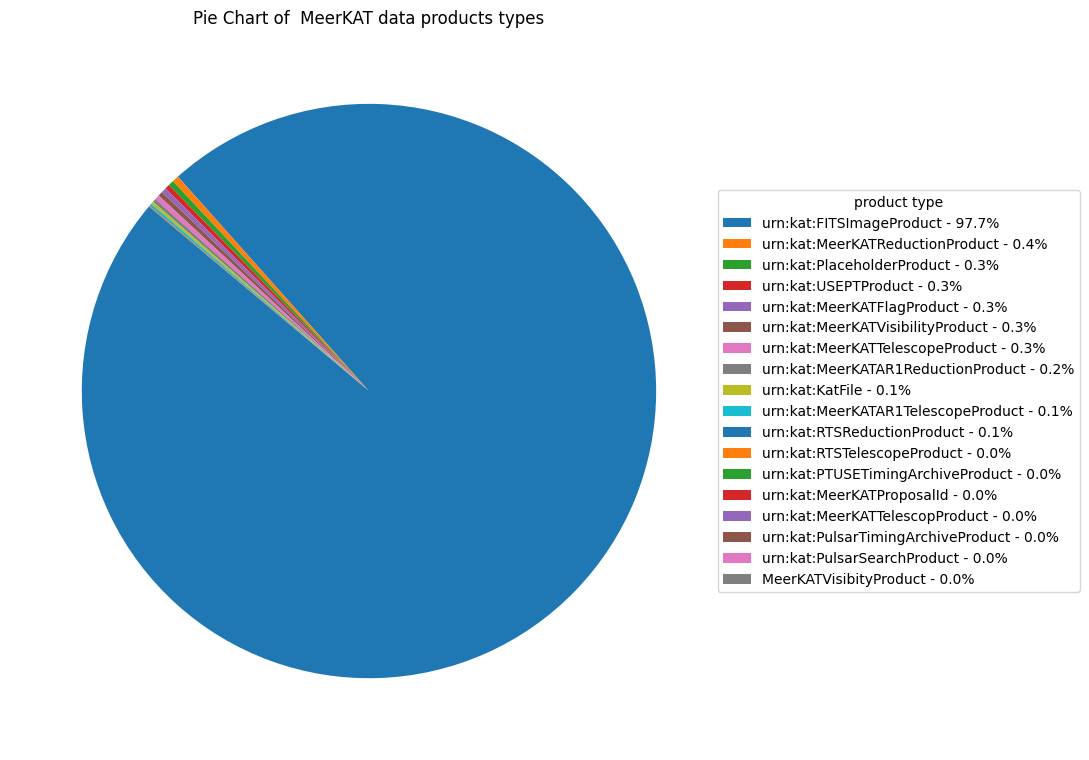

In [ ]:
# Creating the pie chart
plt.figure(figsize=(12, 12))  # Optional: Specifies the figure size
pie_wedges = plt.pie(normalized_frequencies, startangle=140)

# Calculate the percentage of each category to display in the legend
percentages = [f'{value} - {percent:.1f}%' for value, percent in zip(meerkat_products, [v / sum(count) * 100 for v in count])]

# Adding a legend on the side
plt.legend(pie_wedges[0], percentages, title="product type", loc="center right", bbox_to_anchor=(1, 0, 0.5, 1))

# Adding a title
plt.title('Pie Chart of  MeerKAT data products types')

# Adjust layout to make room for the legend
plt.tight_layout()

# Display the plot

#plt.savefig('Data Products types')
plt.show()


#Transfer Status

In [ ]:
# Define the file path where you want to save the JSON file
transfer_status_file_path = 'transfer_status.json'

# Read the JSON file into a DataFrame
df_transfer_status = pd.read_json(transfer_status_file_path)
transfer_status_list = df_transfer_status.values.flatten().tolist()

# Display the DataFrame
status = transfer_status_list[0::2]
freq = transfer_status_list[1::2]
print(status,freq)

['ARCHIVED', 'RECEIVED', 'SPOOLED', 'DELETED', 'SPOOLING', 'RESTAGED', 'RESTAGING', 'DEFUNCT', 'CREATED', 'TRANSFERRING', 'ERROR', 'TRANSFERING', 'RECREATED', 'FAILED'] [8778538, 4115981, 1320295, 811949, 235655, 138684, 66471, 49224, 3922, 560, 308, 152, 5, 4]


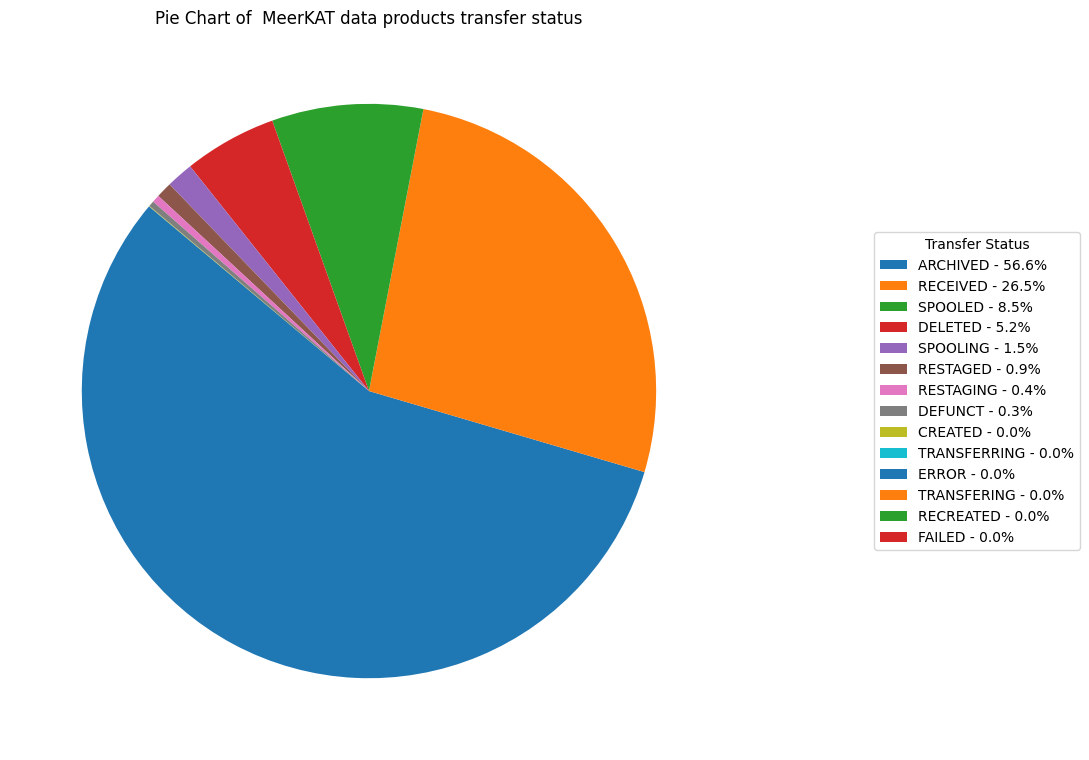

In [ ]:
# Normalize the frequencies using Min-Max normalization
min_freq = min(freq)
max_freq = max(freq)
normalized_frequencies = [(freqz - min_freq) / (max_freq - min_freq) for freqz in freq]

# Creating the pie chart
plt.figure(figsize=(12, 12))  # Optional: Specifies the figure size
pie_wedges = plt.pie(normalized_frequencies, startangle=140)

# Calculate the percentage of each category to display in the legend
percentages = [f'{value} - {percent:.1f}%' for value, percent in zip(status, [v / sum(freq) * 100 for v in freq])]

# Adding a legend on the side
plt.legend(pie_wedges[0], percentages, title="Transfer Status", loc="center right", bbox_to_anchor=(1, 0, 0.5, 1))

# Adding a title
plt.title('Pie Chart of  MeerKAT data products transfer status')

# Adjust layout to make room for the legend
plt.tight_layout()

# Display the plot
plt.savefig('Transfer status')
plt.show()


### Glosarry

Archived - Data is deleted from CEPH and is only on tape.

Spooled - Written to tape

Spooling - Busy writting to tape

Deleted - Data was permenantly deleted and not on tape or CEPH

Received - Data in CEPH and Solr

restaging - Moving an observation from tape back to the archive

restaged - Moved  an observation from tape back to the archive

Defunct - Solr metadata was replaced with another product

created - The data has been created on site (KABP). Hasnt started transferring

recreated - Data/ metadata was recreated by hand

transferring - Busy transferring from KABP to CEPH/SOlr

transfering - Typo ( merge)

Failed - The observation failed. Data not usable ( Created --->failed)

error - Not used anymore

====================================================================

Data created on site to data written to CEPH, Solr(metadata)

Created --> Transferring --> Recieved

====================================================================


Data is written to tape

Recieved ---> Spooling--->spooled

====================================================================

Data deleted from CEPH

spooled ---> archived
restaged--->archived

====================================================================

Data restaged to CEPH

archived ---> restaging---> restaged

====================================================================

## Problem Statement:

The data contains ATTRIBUTES which are categorical and numerical which tells us about the transfer status of an observation from when a block is captured until it get stored in tape.

Our aim here is to **predict the TRANSFER STATUS OF AN OBSERVATION** given we have other attributes of that OBSERVATION. We have many transfer status, however the two statuses that we are predicting is "ARCHIVED" AND "DELETED". The idea status is for an observation metadata to be "ARCHIEVED", when an observation is "DELETED" it suggests the telescope spend time observing but the metadata is not stored.

## Preparing data from SOLR

In this section, we will fetch and prepare the data necessary for our classification task. The steps include retrieving the "ARCHIVED" and "DELETED" observations, combining these datasets, randomizing the rows, and exploring the data to understand its structure and content.

### Steps:
1. **Fetch Data:**
Retrieve metadata for 2000 "ARCHIVED" observations and 1000 "DELETED" observations from the MeerKAT telescope's database.
2. **Combine Datasets:**
Concatenate the "ARCHIVED" and "DELETED" datasets into a single DataFrame.
3. **Randomize Data:**
Shuffle the rows of the combined dataset to ensure a random order, which helps in mitigating any biases during model training.
4. **Explore Data:**
Display the combined dataset to understand the columns and the overall structure of the data. This exploration helps identify any necessary cleaning or preprocessing steps required for model training.

By completing these steps, we ensure that our dataset is well-prepared and provides a clear understanding of the features and target variable we will work with in the classification task.

### Fetching archived observations

Firstly, we will fetch a sample of "ARCHIVED" observations from the MeerKAT telescope's metadata. To avoid excessive internet traffic, we will only retrieve 2000 observations.

In [ ]:
# Define the file path
file_path = 'archived_docs.json'

# Read the JSON file into a DataFrame
archived_df = pd.read_json(file_path)

# Display the DataFrame
archived_df.head()

,CAS.ProductTransferStatus,ElAz,CAS.ReferenceFileSize,CAS.ProductId,MinFreq,StreamId,CAS.ProductName,id,CAS.ProductTypeName,NumFreqChannels,...,Instrument,ProgramBlockId,IssueId,Run,DoNotExpire,RightAscension,Declination,FITSImageFilename,PNGThumbNailFileName,PNGImageFileName
0,ARCHIVED,"[55.991833,-144.927139]","[4096, 100624, 43444964]",1583130032_sdp_l0,856000000.0,sdp_l0,1583130032_sdp_l0,1583130032_sdp_l0,MeerKATTelescopeProduct,4096.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,ARCHIVED,NaN,"[4096, 140933, 94317231]",1583149263_sdp_l0,544000000.0,sdp_l0,1583149263_sdp_l0,1583149263_sdp_l0,MeerKATTelescopeProduct,4096.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,ARCHIVED,NaN,"[8192, 360576, 241262, 170326, 141838, 158740,...",00ff4ea3-4461-4c57-9a18-2d58bee1a5bc,NaN,NaN,1524147354_sdp_l0_calreport_cal.1,00ff4ea3-4461-4c57-9a18-2d58bee1a5bc,MeerKATAR1ReductionProduct,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,ARCHIVED,NaN,"[4096, 199875, 258599, 320336, 187306, 340942,...",fa5dbf48-ad73-4d66-b55a-d237678c3894,NaN,NaN,1524179764_sdp_l0_calreport_cal.1,fa5dbf48-ad73-4d66-b55a-d237678c3894,MeerKATAR1ReductionProduct,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,ARCHIVED,NaN,"[4096, 156993, 338133, 313149, 908503, 621493,...",6bb53ef1-7fcb-4077-97c7-f6b7125df57e,NaN,NaN,1538775215_sdp_l0_calreport_cal.1,6bb53ef1-7fcb-4077-97c7-f6b7125df57e,MeerKATAR1ReductionProduct,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Fetching deleted observations

In addition to the "ARCHIVED" observations, we also need a sample of "DELETED" observations to balance our dataset. Here, we will fetch 1000 "DELETED" observations.

In [ ]:
# Define the file path
file_path = 'deleted_docs.json'

# Read the JSON file into a DataFrame
deleted_df = pd.read_json(file_path)

# Display the DataFrame
deleted_df.head()

,CAS.ProductTransferStatus,CAS.ReferenceFileSize,CAS.ProductId,MinFreq,StreamId,CAS.ProductName,id,CAS.ProductTypeName,NumFreqChannels,CAS.ReferenceMimeType,...,Declination,RightAscension,PNGThumbNailFileName,Run,FITSImageFilename,ReductionName,Prefix,ProductExpireTime,PNGImageFileName,Public
0,DELETED,"[68, 15749323]",../../home/kat/tbennett/git/katsdpdata/katsdpf...,8.560000e+08,sdp_l0,../../home/kat/tbennett/git/katsdpdata/katsdpf...,../../home/kat/tbennett/git/katsdpdata/katsdpf...,MeerKATTelescopeProduct,4096,"[application/x-data, application/x-data]",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,DELETED,NaN,1609439464-FITSImageProduct-Spectral+Image-3474,1.005324e+09,NaN,1609439464-FITSImageProduct-Spectral+Image-3474,1609439464-FITSImageProduct-Spectral+Image-3474,MeerKATTelescopeProduct,1,NaN,...,[-65:45:09.1],[4:08:20.38],[1609439464_spectral_image_J0408-6545_03474.fi...,3474.0,[1609439464_spectral_image_J0408-6545_03474.fits],Spectral Image,1609439464-FITSImageProduct/Spectral+Image-3474,2021-09-12T08:13:09Z,NaN,NaN
2,DELETED,NaN,1587911796-FITSImageProduct-Spectral+Image-20437,1.389864e+09,NaN,1587911796-FITSImageProduct-Spectral+Image-20437,1587911796-FITSImageProduct-Spectral+Image-20437,FITSImageProduct,1,NaN,...,[02:12:21],[10:00:28.6],[1587911796_spectral_image_J1000_0212_20437.fi...,20437.0,[1587911796_spectral_image_J1000_0212_20437.fits],Spectral Image,1587911796-fitsimageproduct/Spectral+Image-20437,NaN,[1587911796_spectral_image_J1000_0212_20437.fi...,1.0
3,DELETED,NaN,1587911796-FITSImageProduct-Spectral+Image-20438,1.389890e+09,NaN,1587911796-FITSImageProduct-Spectral+Image-20438,1587911796-FITSImageProduct-Spectral+Image-20438,FITSImageProduct,1,NaN,...,[02:12:21],[10:00:28.6],[1587911796_spectral_image_J1000_0212_20438.fi...,20438.0,[1587911796_spectral_image_J1000_0212_20438.fits],Spectral Image,1587911796-fitsimageproduct/Spectral+Image-20438,NaN,[1587911796_spectral_image_J1000_0212_20438.fi...,1.0
4,DELETED,NaN,1587911796-FITSImageProduct-Spectral+Image-20439,1.389916e+09,NaN,1587911796-FITSImageProduct-Spectral+Image-20439,1587911796-FITSImageProduct-Spectral+Image-20439,FITSImageProduct,1,NaN,...,[02:12:21],[10:00:28.6],[1587911796_spectral_image_J1000_0212_20439.fi...,20439.0,[1587911796_spectral_image_J1000_0212_20439.fits],Spectral Image,1587911796-fitsimageproduct/Spectral+Image-20439,NaN,[1587911796_spectral_image_J1000_0212_20439.fi...,1.0


### Inspecting the data

We'll have a look at the deleted data to gain some insight into the different columns that are present in the data. If we observe the data below, the first thing that jumps out is the amount of NaN values, which we will have to deal with later

In [ ]:
deleted_df.head()

,CAS.ProductTransferStatus,CAS.ReferenceFileSize,CAS.ProductId,MinFreq,StreamId,CAS.ProductName,id,CAS.ProductTypeName,NumFreqChannels,CAS.ReferenceMimeType,...,Declination,RightAscension,PNGThumbNailFileName,Run,FITSImageFilename,ReductionName,Prefix,ProductExpireTime,PNGImageFileName,Public
0,DELETED,"[68, 15749323]",../../home/kat/tbennett/git/katsdpdata/katsdpf...,8.560000e+08,sdp_l0,../../home/kat/tbennett/git/katsdpdata/katsdpf...,../../home/kat/tbennett/git/katsdpdata/katsdpf...,MeerKATTelescopeProduct,4096,"[application/x-data, application/x-data]",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,DELETED,NaN,1609439464-FITSImageProduct-Spectral+Image-3474,1.005324e+09,NaN,1609439464-FITSImageProduct-Spectral+Image-3474,1609439464-FITSImageProduct-Spectral+Image-3474,MeerKATTelescopeProduct,1,NaN,...,[-65:45:09.1],[4:08:20.38],[1609439464_spectral_image_J0408-6545_03474.fi...,3474.0,[1609439464_spectral_image_J0408-6545_03474.fits],Spectral Image,1609439464-FITSImageProduct/Spectral+Image-3474,2021-09-12T08:13:09Z,NaN,NaN
2,DELETED,NaN,1587911796-FITSImageProduct-Spectral+Image-20437,1.389864e+09,NaN,1587911796-FITSImageProduct-Spectral+Image-20437,1587911796-FITSImageProduct-Spectral+Image-20437,FITSImageProduct,1,NaN,...,[02:12:21],[10:00:28.6],[1587911796_spectral_image_J1000_0212_20437.fi...,20437.0,[1587911796_spectral_image_J1000_0212_20437.fits],Spectral Image,1587911796-fitsimageproduct/Spectral+Image-20437,NaN,[1587911796_spectral_image_J1000_0212_20437.fi...,1.0
3,DELETED,NaN,1587911796-FITSImageProduct-Spectral+Image-20438,1.389890e+09,NaN,1587911796-FITSImageProduct-Spectral+Image-20438,1587911796-FITSImageProduct-Spectral+Image-20438,FITSImageProduct,1,NaN,...,[02:12:21],[10:00:28.6],[1587911796_spectral_image_J1000_0212_20438.fi...,20438.0,[1587911796_spectral_image_J1000_0212_20438.fits],Spectral Image,1587911796-fitsimageproduct/Spectral+Image-20438,NaN,[1587911796_spectral_image_J1000_0212_20438.fi...,1.0
4,DELETED,NaN,1587911796-FITSImageProduct-Spectral+Image-20439,1.389916e+09,NaN,1587911796-FITSImageProduct-Spectral+Image-20439,1587911796-FITSImageProduct-Spectral+Image-20439,FITSImageProduct,1,NaN,...,[02:12:21],[10:00:28.6],[1587911796_spectral_image_J1000_0212_20439.fi...,20439.0,[1587911796_spectral_image_J1000_0212_20439.fits],Spectral Image,1587911796-fitsimageproduct/Spectral+Image-20439,NaN,[1587911796_spectral_image_J1000_0212_20439.fi...,1.0


### Data concatenation

After collecting the "ARCHIVED" and "DELETED" observations, we need to combine and randomize the data to prepare it for the classification task.

In [ ]:
# Concatenating the dataframes by rows with ARCHIVED and DELETED observation metadata
concatenated_df = pd.concat([archived_df, deleted_df], ignore_index=True)

# Randomizing the rows of the concatenated dataframe
randomized_df = concatenated_df.sample(frac=1).reset_index(drop=True)

Next we'll look at the head and the tail of the dataframe to verify that our concatenation and randomisation worked

In [ ]:
randomized_df.head()

,CAS.ProductTransferStatus,ElAz,CAS.ReferenceFileSize,CAS.ProductId,MinFreq,StreamId,CAS.ProductName,id,CAS.ProductTypeName,NumFreqChannels,...,Instrument,ProgramBlockId,IssueId,Run,DoNotExpire,RightAscension,Declination,FITSImageFilename,PNGThumbNailFileName,PNGImageFileName
0,ARCHIVED,NaN,NaN,1598743058-MeerKATReductionProduct-Calibration...,NaN,NaN,1598743058-MeerKATReductionProduct-Calibration...,1598743058-MeerKATReductionProduct-Calibration...,MeerKATReductionProduct,NaN,...,NaN,NaN,NaN,1.0,1.0,NaN,NaN,NaN,NaN,NaN
1,DELETED,NaN,NaN,1587911796-FITSImageProduct-Spectral+Image-21060,1.406138e+09,NaN,1587911796-FITSImageProduct-Spectral+Image-21060,1587911796-FITSImageProduct-Spectral+Image-21060,FITSImageProduct,1.0,...,NaN,NaN,NaN,21060.0,NaN,[10:00:28.6],[02:12:21],[1587911796_spectral_image_J1000_0212_21060.fits],[1587911796_spectral_image_J1000_0212_21060.fi...,[1587911796_spectral_image_J1000_0212_21060.fi...
2,DELETED,NaN,NaN,1587911796-FITSImageProduct-Spectral+Image-20809,1.399581e+09,NaN,1587911796-FITSImageProduct-Spectral+Image-20809,1587911796-FITSImageProduct-Spectral+Image-20809,FITSImageProduct,1.0,...,NaN,NaN,NaN,20809.0,NaN,[10:00:28.6],[02:12:21],[1587911796_spectral_image_J1000_0212_20809.fits],[1587911796_spectral_image_J1000_0212_20809.fi...,[1587911796_spectral_image_J1000_0212_20809.fi...
3,ARCHIVED,NaN,NaN,1585413022-FITSImageProduct-Spectral+Image-17313,1.308255e+09,NaN,1585413022-FITSImageProduct-Spectral+Image-17313,1585413022-FITSImageProduct-Spectral+Image-17313,FITSImageProduct,1.0,...,NaN,NaN,NaN,17313.0,NaN,[09:59:03.68],[02:12:21],[1585413022_spectral_image_J0959_0212_17313.fits],[1585413022_spectral_image_J0959_0212_17313.fi...,[1585413022_spectral_image_J0959_0212_17313.fi...
4,ARCHIVED,NaN,NaN,1597962284-MeerKATReductionProduct-Calibration...,NaN,NaN,1597962284-MeerKATReductionProduct-Calibration...,1597962284-MeerKATReductionProduct-Calibration...,MeerKATReductionProduct,NaN,...,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
randomized_df.tail()

,CAS.ProductTransferStatus,ElAz,CAS.ReferenceFileSize,CAS.ProductId,MinFreq,StreamId,CAS.ProductName,id,CAS.ProductTypeName,NumFreqChannels,...,Instrument,ProgramBlockId,IssueId,Run,DoNotExpire,RightAscension,Declination,FITSImageFilename,PNGThumbNailFileName,PNGImageFileName
2995,ARCHIVED,NaN,NaN,1585413022-FITSImageProduct-Spectral+Image-17029,1.300836e+09,NaN,1585413022-FITSImageProduct-Spectral+Image-17029,1585413022-FITSImageProduct-Spectral+Image-17029,FITSImageProduct,1.0,...,NaN,NaN,NaN,17029.0,NaN,[09:59:03.68],[02:12:21],[1585413022_spectral_image_J0959_0212_17029.fits],[1585413022_spectral_image_J0959_0212_17029.fi...,[1585413022_spectral_image_J0959_0212_17029.fi...
2996,ARCHIVED,NaN,NaN,1585413022-FITSImageProduct-Spectral+Image-1744,9.015455e+08,NaN,1585413022-FITSImageProduct-Spectral+Image-1744,1585413022-FITSImageProduct-Spectral+Image-1744,FITSImageProduct,1.0,...,NaN,NaN,NaN,1744.0,NaN,[09:59:03.68],[02:12:21],[1585413022_spectral_image_J0959_0212_01744.fits],[1585413022_spectral_image_J0959_0212_01744.fi...,[1585413022_spectral_image_J0959_0212_01744.fi...
2997,ARCHIVED,NaN,NaN,1597477257-MeerKATReductionProduct-Calibration...,NaN,NaN,1597477257-MeerKATReductionProduct-Calibration...,1597477257-MeerKATReductionProduct-Calibration...,MeerKATReductionProduct,NaN,...,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN
2998,DELETED,NaN,NaN,1587911796-FITSImageProduct-Spectral+Image-21033,1.405433e+09,NaN,1587911796-FITSImageProduct-Spectral+Image-21033,1587911796-FITSImageProduct-Spectral+Image-21033,FITSImageProduct,1.0,...,NaN,NaN,NaN,21033.0,NaN,[10:00:28.6],[02:12:21],[1587911796_spectral_image_J1000_0212_21033.fits],[1587911796_spectral_image_J1000_0212_21033.fi...,[1587911796_spectral_image_J1000_0212_21033.fi...
2999,ARCHIVED,NaN,NaN,1585413022-FITSImageProduct-Spectral+Image-17512,1.313454e+09,NaN,1585413022-FITSImageProduct-Spectral+Image-17512,1585413022-FITSImageProduct-Spectral+Image-17512,FITSImageProduct,1.0,...,NaN,NaN,NaN,17512.0,NaN,[09:59:03.68],[02:12:21],[1585413022_spectral_image_J0959_0212_17512.fits],[1585413022_spectral_image_J0959_0212_17512.fi...,[1585413022_spectral_image_J0959_0212_17512.fi...


In [ ]:
pd.set_option('display.max_columns', None)
randomized_df.sample(5)

,CAS.ProductTransferStatus,ElAz,CAS.ReferenceFileSize,CAS.ProductId,MinFreq,StreamId,CAS.ProductName,id,CAS.ProductTypeName,NumFreqChannels,CAS.ReferenceMimeType,Description,KatfileVersion,Bandwidth,InstructionSet,CaptureBlockId,Antennas,RefAntenna,ChannelWidth,CAS.ReferenceOriginal,MaxFreq,CAS.ProductTypeId,ProposalId,ExperimentID,CAS.ProductStructure,CenterFrequency,DumpPeriod,ScheduleBlockIdCode,CaptureStreamId,Observer,Observer_lowercase,CAS.ProductReceivedTime,Prefix,FileSize,StartTime,CAS.ReferenceDatastore,Duration,KatpointTargets,Targets,TargetsString,Details,ReferenceTapeStore,IntegrationTime,_version_,DecRa,DelayCal,ReductionName,MimeTypesHierarchy,Filename,ProductName,Public,ProductExpireTime,ProductArchivedTime,QA1,Instrument,ProgramBlockId,IssueId,Run,DoNotExpire,RightAscension,Declination,FITSImageFilename,PNGThumbNailFileName,PNGImageFileName
1040,DELETED,NaN,NaN,1587911796-FITSImageProduct-Spectral+Image-20491,1.391274e+09,NaN,1587911796-FITSImageProduct-Spectral+Image-20491,1587911796-FITSImageProduct-Spectral+Image-20491,FITSImageProduct,1.0,NaN,MIGHTEE COSMOS: Spectral-line image,NaN,2.612305e+04,NaN,1587911796,NaN,NaN,26123.046875,[file:///data/1587911796_spectral_image_J1000_...,1.391300e+09,urn:kat:FITSImageProduct,SCI-20180516-KH-01,NaN,NaN,1.391287e+09,NaN,20200424-0023,NaN,Ian Heywood,Ian Heywood,NaN,1587911796-fitsimageproduct/Spectral+Image-20491,NaN,2020-04-27T12:14:12.114Z,[s3://1587911796-FITSImageProduct/Spectral+Ima...,NaN,"[J1000+0212 | COSMOS, radec target, 10:00:28.6...",[J1000+0212],[J1000+0212],NaN,NaN,[6.239582520028],1780909467733327873,"[2.2058333333,150.11916666670004]",NaN,Spectral Image,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,20491.0,NaN,[10:00:28.6],[02:12:21],[1587911796_spectral_image_J1000_0212_20491.fits],[1587911796_spectral_image_J1000_0212_20491.fi...,[1587911796_spectral_image_J1000_0212_20491.fi...
1993,ARCHIVED,NaN,NaN,1598643992-MeerKATReductionProduct-Calibration...,NaN,NaN,1598643992-MeerKATReductionProduct-Calibration...,1598643992-MeerKATReductionProduct-Calibration...,MeerKATReductionProduct,NaN,NaN,Delaycal cal report,NaN,NaN,NaN,1598643992,NaN,NaN,NaN,[file:///data/1598643992_sdp_l0_calreport_cal....,NaN,urn:kat:MeerKATReductionProduct,CAL-20200106-OP-02,NaN,NaN,NaN,NaN,20200828-0015,NaN,Operator,Operator,NaN,1598643992-meerkatreductionproduct/Calibration...,NaN,2020-08-28T19:46:41Z,[s3://1598643992-MeerKATReductionProduct/Calib...,NaN,NaN,NaN,NaN,NaN,[tape://LIB_CHPC_IBM/TS_1624214149/BF_8192/LTO...,NaN,1780909087341412357,NaN,NaN,Calibration Report,NaN,NaN,NaN,NaN,2021-03-16T19:46:32Z,2021-06-21T15:32:02Z,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN
730,ARCHIVED,NaN,"[4096, 82348, 87492911]",1599133188_sdp_l0,8.560000e+08,sdp_l0,1599133188_sdp_l0,1599133188_sdp_l0,MeerKATTelescopeProduct,4096.0,"[application/x-data, application/x-data, appli...",MeerTRAP - track on Vela,4.0,8.560000e+08,/home/kat/katsdpscripts/observation/track.py -...,1599133188,"[m000, m002, m004, m005, m006, m007, m008, m00...",array,208984.375000,"[file:///data/1599133188, file:///data/1599133...",1.712000e+09,urn:kat:MeerKATTelescopeProduct,COM-20191128-DH-01,20200903-0012,Hierarchical,1.283791e+09,7.9966,20200903-0012,1599133188_sdp_l0,DaveHorn,DaveHorn,2020-09-03T12:44:23Z,1599133188,[82000216064],2020-09-03T11:40:57Z,"[s3://1599133188, s3://1599133188/1599133188_s...",3630.46,"[J0835-4510, radec, 8:35:20.61, -45:10:34.9]",[J0835-4510],[J0835-4510],==============================================...,[tape://LIB_CHPC_IBM/TS_1624369318/BF_8192/LTO...,[3598.0],1729346272974864384,"[-45.176361,128.835875]",NaN,NaN,NaN,NaN,NaN,NaN,2021-03-22T11:39:48Z,2021-07-02T13:46:29Z,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
810,ARCHIVED,NaN,NaN,1597169760-MeerKATReductionProduct-Calibration...,NaN,NaN,1597169760-MeerKATReductionProduct-Calibration...,1597169760-MeerKATReductionProduct-Calibration...,MeerKATReductionProduct,NaN,NaN,TRAPUM phase up with flatten bandpass cal report,NaN,NaN,NaN,1597169760,NaN,N

## Data Cleaning

In this section, we will perform essential data cleaning steps to prepare our dataset for model training. This involves identifying and handling missing data and splitting the dataset into input features and the target variable.

### Steps:
1. **Identify Missing Data:**
We will inspect the dataset to determine which columns have the most missing values.
2. **Drop Columns with Excessive Missing Data:**
Columns with more than 90% of their data missing will be removed from the dataset to ensure data quality and reduce noise.
3. **Split the Dataset:**
We will split the cleaned dataset into input features (X) and the target variable (y), which represents the transfer status of the observations.

By following these steps, we ensure that our dataset is clean and well-prepared for the subsequent analysis and model training.

### Missing Data

Let's see how much data each columns is missing.

In [ ]:
# Set display options to view all rows and columns
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

missing_percentage = (randomized_df.isnull().sum() / len(randomized_df)) * 100
print(missing_percentage.apply(lambda x: f'{x:.2f}%'))

CAS.ProductTransferStatus     0.00%
ElAz                         99.90%
CAS.ReferenceFileSize        93.20%
CAS.ProductId                 0.00%
MinFreq                      31.97%
StreamId                     93.40%
CAS.ProductName               0.00%
id                            0.00%
CAS.ProductTypeName           0.00%
NumFreqChannels              31.97%
CAS.ReferenceMimeType        93.20%
Description                   0.20%
KatfileVersion               93.40%
Bandwidth                    31.97%
InstructionSet               94.23%
CaptureBlockId                0.00%
Antennas                     93.40%
RefAntenna                   93.60%
ChannelWidth                 31.97%
CAS.ReferenceOriginal         0.00%
MaxFreq                      31.97%
CAS.ProductTypeId             0.00%
ProposalId                    1.03%
ExperimentID                 94.23%
CAS.ProductStructure         93.20%
CenterFrequency              32.67%
DumpPeriod                   93.40%
ScheduleBlockIdCode         

#### Handling Missing values

In this section, we address the missing data in our dataset. First, we identify the columns with the highest percentage of missing values. Then, we drop the columns that have more than 90% of their data missing to ensure that our dataset remains robust and reliable.

In [ ]:
# Define the threshold
threshold = 90

# Get the columns to drop
columns_to_drop = missing_percentage[missing_percentage > threshold].index
print(columns_to_drop)
# # Drop the columns from the DataFrame
df_cleaned = randomized_df.drop(columns=columns_to_drop)

# # Display the cleaned DataFrame
print("\nDataFrame after dropping columns with more than 90% missing values:")
df_cleaned.head()

Index(['ElAz', 'CAS.ReferenceFileSize', 'StreamId', 'CAS.ReferenceMimeType',
       'KatfileVersion', 'InstructionSet', 'Antennas', 'RefAntenna',
       'ExperimentID', 'CAS.ProductStructure', 'DumpPeriod', 'CaptureStreamId',
       'CAS.ProductReceivedTime', 'FileSize', 'Duration', 'Details',
       'DelayCal', 'MimeTypesHierarchy', 'Filename', 'ProductName', 'QA1',
       'Instrument', 'ProgramBlockId', 'IssueId', 'DoNotExpire'],
      dtype='object')

DataFrame after dropping columns with more than 90% missing values:


,CAS.ProductTransferStatus,CAS.ProductId,MinFreq,CAS.ProductName,id,CAS.ProductTypeName,NumFreqChannels,Description,Bandwidth,CaptureBlockId,ChannelWidth,CAS.ReferenceOriginal,MaxFreq,CAS.ProductTypeId,ProposalId,CenterFrequency,ScheduleBlockIdCode,Observer,Observer_lowercase,Prefix,StartTime,CAS.ReferenceDatastore,KatpointTargets,Targets,TargetsString,ReferenceTapeStore,IntegrationTime,_version_,DecRa,ReductionName,Public,ProductExpireTime,ProductArchivedTime,Run,RightAscension,Declination,FITSImageFilename,PNGThumbNailFileName,PNGImageFileName
0,ARCHIVED,1598743058-MeerKATReductionProduct-Calibration...,NaN,1598743058-MeerKATReductionProduct-Calibration...,1598743058-MeerKATReductionProduct-Calibration...,MeerKATReductionProduct,NaN,LSB48-J0212/J0216/J0217 cal report,NaN,1598743058,NaN,[file:///data/1598743058_sdp_l0_calreport_cal....,NaN,urn:kat:MeerKATReductionProduct,SCI-20180516-NG-01,NaN,20200809-0005,Neeraj Gupta,Neeraj Gupta,1598743058-meerkatreductionproduct/Calibration...,2020-08-29T23:17:55Z,[s3://1598743058-MeerKATReductionProduct/Calib...,NaN,NaN,NaN,[tape://LIB_CHPC_IBM/TS_1624086270/BF_8192/LTO...,NaN,1780909087344558088,NaN,Calibration Report,NaN,2021-03-17T23:17:38Z,2021-06-19T15:31:33Z,1.0,NaN,NaN,NaN,NaN,NaN
1,DELETED,1587911796-FITSImageProduct-Spectral+Image-21060,1.406138e+09,1587911796-FITSImageProduct-Spectral+Image-21060,1587911796-FITSImageProduct-Spectral+Image-21060,FITSImageProduct,1.0,MIGHTEE COSMOS: Spectral-line image,26123.046875,1587911796,26123.046875,[file:///data/1587911796_spectral_image_J1000_...,1.406164e+09,urn:kat:FITSImageProduct,SCI-20180516-KH-01,1.406151e+09,20200424-0023,Ian Heywood,Ian Heywood,1587911796-fitsimageproduct/Spectral+Image-21060,2020-04-27T12:15:01.291Z,[s3://1587911796-FITSImageProduct/Spectral+Ima...,"[J1000+0212 | COSMOS, radec target, 10:00:28.6...",[J1000+0212],[J1000+0212],NaN,[6.239582520028],1780909467788902404,"[2.2058333333,150.11916666670004]",Spectral Image,1.0,NaN,NaN,21060.0,[10:00:28.6],[02:12:21],[1587911796_spectral_image_J1000_0212_21060.fits],[1587911796_spectral_image_J1000_0212_21060.fi...,[1587911796_spectral_image_J1000_0212_21060.fi...
2,DELETED,1587911796-FITSImageProduct-Spectral+Image-20809,1.399581e+09,1587911796-FITSImageProduct-Spectral+Image-20809,1587911796-FITSImageProduct-Spectral+Image-20809,FITSImageProduct,1.0,MIGHTEE COSMOS: Spectral-line image,26123.046875,1587911796,26123.046875,[file:///data/1587911796_spectral_image_J1000_...,1.399608e+09,urn:kat:FITSImageProduct,SCI-20180516-KH-01,1.399594e+09,20200424-0023,Ian Heywood,Ian Heywood,1587911796-fitsimageproduct/Spectral+Image-20809,2020-04-27T12:14:45.077Z,[s3://1587911796-FITSImageProduct/Spectral+Ima...,"[J1000+0212 | COSMOS, radec target, 10:00:28.6...",[J1000+0212],[J1000+0212],NaN,[6.239582520028],1780909467763736585,"[2.2058333333,150.11916666670004]",Spectral Image,1.0,NaN,NaN,20809.0,[10:00:28.6],[02:12:21],[1587911796_spectral_image_J1000_0212_20809.fits],[1587911796_spectral_image_J1000_0212_20809.fi...,[1587911796_spectral_image_J1000_0212_20809.fi...
3,ARCHIVED,1585413022-FITSImageProduct-Spectral+Image-17313,1.308255e+09,1585413022-FITSImageProduct-Spectral+Image-17313,1585413022-FITSImageProduct-Spectral+Image-17313,FITSImageProduct,1.0,MIGHTEE COSMOS_5: Spectral-line image,26123.046875,1585413022,26123.046875,[file:///data/1585413022_spectral_image_J0959_...,1.308281e+09,urn:kat:FITSImageProduct,SCI-20180516-KH-01,1.308268e+09,20200325-0009,Ian Heywood,Ian Heywood,1585413022-fitsimageproduct/Spectral+Image-17313,2020-03-29T14:40:06.817Z,[s3://1585413022-FITSImageProduct/Spectral+Ima...,"[J0959+0212 | COSMOS_5, radec target, 9:59:03....",[J0959+0212],[J0959+0212],[tape://LIB_CHPC_IBM/TS_1610021949/BF_8192/LTO...,[6.239582520028],1780909362041061380,"[2.2058333333,149.76533333329996]",Spectral Image,1.0,2020-10-14T16:30:22Z,2021-04-22T15:22:44Z,17313.0,[09:59:03.68],[02:12:21],[1585413022_spectral_image_J0959_0212_17313.fits],[1585413022_spectral_image_J0959_0212_

### Feature selection

In this section, we select the features that are most likely to contribute to predicting the transfer status of the observations. This step is crucial as it helps us focus on the relevant attributes and reduces the dimensionality of the dataset, making the model training process more efficient.

In [ ]:
# define a list of columns that are likely to be relevant for predicting the transfer status
selected_columns = ['CAS.ProductTransferStatus','CAS.ProductTypeName','NumFreqChannels','Bandwidth','ChannelWidth','MaxFreq','CAS.ProductTypeId','CenterFrequency','ScheduleBlockIdCode','Observer','StartTime','ReductionName','ProductExpireTime','ProductArchivedTime','Run']

# print the shape of the cleaned DataFrame and the
# number of selected columns to ensure that our
# selection process is accurate and manageable
print(f'Original # of columns: {df_cleaned.shape[-1]}')
print(f'New number of columns: {len(selected_columns)}')

Original # of columns: 39
New number of columns: 15


Next we will drop columns and only keep columns with sufficient amount of data

In [ ]:
selected_df = df_cleaned[selected_columns]
selected_df.head()

,CAS.ProductTransferStatus,CAS.ProductTypeName,NumFreqChannels,Bandwidth,ChannelWidth,MaxFreq,CAS.ProductTypeId,CenterFrequency,ScheduleBlockIdCode,Observer,StartTime,ReductionName,ProductExpireTime,ProductArchivedTime,Run
0,ARCHIVED,MeerKATReductionProduct,NaN,NaN,NaN,NaN,urn:kat:MeerKATReductionProduct,NaN,20200809-0005,Neeraj Gupta,2020-08-29T23:17:55Z,Calibration Report,2021-03-17T23:17:38Z,2021-06-19T15:31:33Z,1.0
1,DELETED,FITSImageProduct,1.0,26123.046875,26123.046875,1.406164e+09,urn:kat:FITSImageProduct,1.406151e+09,20200424-0023,Ian Heywood,2020-04-27T12:15:01.291Z,Spectral Image,NaN,NaN,21060.0
2,DELETED,FITSImageProduct,1.0,26123.046875,26123.046875,1.399608e+09,urn:kat:FITSImageProduct,1.399594e+09,20200424-0023,Ian Heywood,2020-04-27T12:14:45.077Z,Spectral Image,NaN,NaN,20809.0
3,ARCHIVED,FITSImageProduct,1.0,26123.046875,26123.046875,1.308281e+09,urn:kat:FITSImageProduct,1.308268e+09,20200325-0009,Ian Heywood,2020-03-29T14:40:06.817Z,Spectral Image,2020-10-14T16:30:22Z,2021-04-22T15:22:44Z,17313.0
4,ARCHIVED,MeerKATReductionProduct,NaN,NaN,NaN,NaN,urn:kat:MeerKATReductionProduct,NaN,20200820-0031,Samuel Legodi,2020-08-20T22:24:48Z,Calibration Report,2021-03-08T22:24:44Z,2021-06-21T15:32:29Z,1.0


Verify new data's columns has less than 90% data missing

In [ ]:
# Set display options to view all rows and columns
missing_percentage = (selected_df.isnull().sum() / len(selected_df)) * 100
print(missing_percentage)

CAS.ProductTransferStatus     0.000000
CAS.ProductTypeName           0.000000
NumFreqChannels              31.966667
Bandwidth                    31.966667
ChannelWidth                 31.966667
MaxFreq                      31.966667
CAS.ProductTypeId             0.000000
CenterFrequency              32.666667
ScheduleBlockIdCode           1.033333
Observer                      1.033333
StartTime                     0.200000
ReductionName                 6.600000
ProductExpireTime            34.400000
ProductArchivedTime          34.433333
Run                           6.800000
dtype: float64


### Separate Features and Target Variable

In this section, we separate the input features from the target variable to prepare the dataset for model training. This step is crucial as it allows us to train our model using the input features (X) while predicting the target variable (y).

In [ ]:
# Separate features and target variable
x_data = selected_df.drop('CAS.ProductTransferStatus', axis=1)
y_data = selected_df['CAS.ProductTransferStatus']
x_data.head()

,CAS.ProductTypeName,NumFreqChannels,Bandwidth,ChannelWidth,MaxFreq,CAS.ProductTypeId,CenterFrequency,ScheduleBlockIdCode,Observer,StartTime,ReductionName,ProductExpireTime,ProductArchivedTime,Run
0,MeerKATReductionProduct,NaN,NaN,NaN,NaN,urn:kat:MeerKATReductionProduct,NaN,20200809-0005,Neeraj Gupta,2020-08-29T23:17:55Z,Calibration Report,2021-03-17T23:17:38Z,2021-06-19T15:31:33Z,1.0
1,FITSImageProduct,1.0,26123.046875,26123.046875,1.406164e+09,urn:kat:FITSImageProduct,1.406151e+09,20200424-0023,Ian Heywood,2020-04-27T12:15:01.291Z,Spectral Image,NaN,NaN,21060.0
2,FITSImageProduct,1.0,26123.046875,26123.046875,1.399608e+09,urn:kat:FITSImageProduct,1.399594e+09,20200424-0023,Ian Heywood,2020-04-27T12:14:45.077Z,Spectral Image,NaN,NaN,20809.0
3,FITSImageProduct,1.0,26123.046875,26123.046875,1.308281e+09,urn:kat:FITSImageProduct,1.308268e+09,20200325-0009,Ian Heywood,2020-03-29T14:40:06.817Z,Spectral Image,2020-10-14T16:30:22Z,2021-04-22T15:22:44Z,17313.0
4,MeerKATReductionProduct,NaN,NaN,NaN,NaN,urn:kat:MeerKATReductionProduct,NaN,20200820-0031,Samuel Legodi,2020-08-20T22:24:48Z,Calibration Report,2021-03-08T22:24:44Z,2021-06-21T15:32:29Z,1.0


In [ ]:
y_data.head()

0    ARCHIVED
1     DELETED
2     DELETED
3    ARCHIVED
4    ARCHIVED
Name: CAS.ProductTransferStatus, dtype: object

## Model Building and Evaluation

In this section, we will build and evaluate our models to predict the transfer status of observations using the prepared dataset. We will perform the following steps to ensure our models are robust and effective:


1. **Identify Numerical and Categorical Columns:**

We will categorize our features into numerical and categorical columns to apply appropriate preprocessing techniques.

2. **Preprocessing for Numerical Data:**

We will create a preprocessing pipeline for numerical data, which includes:
- Imputing missing values using the mean strategy.
- Scaling the features using StandardScaler to standardize the data.

3. **Preprocessing for Categorical Data:**

We will create a preprocessing pipeline for categorical data, which includes:
- Imputing missing values using the most frequent strategy.
- Encoding categorical variables using OneHotEncoder

4. **Combine Preprocessing Steps:**

We will combine the preprocessing steps for both numerical and categorical data into a single preprocessor.

5. **Create Models:**

We will create two models with hyperparameters to prevent overfitting:
- A Random Forest classifier.
- An XGBoost classifier.

6. **Create and Evaluate Pipelines:**

We will create pipelines for each model that include the preprocessor and the model itself.

7. **Apply Transformations:**

We will apply the transformations defined in the pipelines to preprocess the data.

8. **Train Models:**

We will train the Random Forest and XGBoost models using the training data.

9. **Evaluate Models:**

Finally, we will evaluate the performance of the trained models to determine their effectiveness in predicting the transfer status of observations.

In [ ]:
#importing sklearn librabies
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from xgboost import XGBClassifier

### Identify Numerical and Categorical Columns
Before we proceed with preprocessing, it is essential to distinguish between numerical and categorical features in our dataset. This distinction allows us to apply appropriate preprocessing techniques to each type of data.


In [ ]:
# Identify numerical and categorical columns
numerical_features = x_data.select_dtypes(include=['float64', 'int64']).columns
categorical_features = x_data.select_dtypes(include=['object']).columns

In [ ]:
print(numerical_features,"\n" ,categorical_features)

Index(['NumFreqChannels', 'Bandwidth', 'ChannelWidth', 'MaxFreq',
       'CenterFrequency', 'Run'],
      dtype='object') 
 Index(['CAS.ProductTypeName', 'CAS.ProductTypeId', 'ScheduleBlockIdCode',
       'Observer', 'StartTime', 'ReductionName', 'ProductExpireTime',
       'ProductArchivedTime'],
      dtype='object')


### Extract Numerical Features

In this step, we extract the numerical features from the dataset for further preprocessing.

In [ ]:
numerical_df = x_data[numerical_features]
numerical_df.head()

,NumFreqChannels,Bandwidth,ChannelWidth,MaxFreq,CenterFrequency,Run
0,NaN,NaN,NaN,NaN,NaN,1.0
1,1.0,26123.046875,26123.046875,1.406164e+09,1.406151e+09,21060.0
2,1.0,26123.046875,26123.046875,1.399608e+09,1.399594e+09,20809.0
3,1.0,26123.046875,26123.046875,1.308281e+09,1.308268e+09,17313.0
4,NaN,NaN,NaN,NaN,NaN,1.0


### Preprocessing for Numerical Data
To prepare the numerical features for model training, we will create a preprocessing pipeline that includes imputation and scaling steps.

- **Creating a Pipeline:**
We define a pipeline, numerical_transformer, that consists of two main steps: imputation and scaling. This pipeline will be applied to the numerical features of our dataset.

#### Simple Imputer

**Purpose:** Handles missing values in the numerical data.

**Function:** The SimpleImputer fills in missing values using the mean value of each numerical feature. This strategy ensures that missing data does not disrupt the model training process and provides a reasonable estimate based on available data.


#### StandardScaler


**Purpose:** Standardizes the numerical features.

**Function:** The StandardScaler transforms the data by scaling each feature to have a mean of 0 and a standard deviation of 1. This standardization process is crucial because it ensures that all numerical features contribute equally to the model, preventing features with larger scales from dominating the learning process.


_By applying this preprocessing pipeline, we ensure that the numerical data is clean and standardized, ready for efficient and effective model training._

In [ ]:
# Preprocessing for numerical data
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

### Extract Categorical Features

In this step, we extract the categorical features from the dataset for further preprocessing.

In [ ]:
categorial_df = x_data[categorical_features]
categorial_df.head()

,CAS.ProductTypeName,CAS.ProductTypeId,ScheduleBlockIdCode,Observer,StartTime,ReductionName,ProductExpireTime,ProductArchivedTime
0,MeerKATReductionProduct,urn:kat:MeerKATReductionProduct,20200809-0005,Neeraj Gupta,2020-08-29T23:17:55Z,Calibration Report,2021-03-17T23:17:38Z,2021-06-19T15:31:33Z
1,FITSImageProduct,urn:kat:FITSImageProduct,20200424-0023,Ian Heywood,2020-04-27T12:15:01.291Z,Spectral Image,NaN,NaN
2,FITSImageProduct,urn:kat:FITSImageProduct,20200424-0023,Ian Heywood,2020-04-27T12:14:45.077Z,Spectral Image,NaN,NaN
3,FITSImageProduct,urn:kat:FITSImageProduct,20200325-0009,Ian Heywood,2020-03-29T14:40:06.817Z,Spectral Image,2020-10-14T16:30:22Z,2021-04-22T15:22:44Z
4,MeerKATReductionProduct,urn:kat:MeerKATReductionProduct,20200820-0031,Samuel Legodi,2020-08-20T22:24:48Z,Calibration Report,2021-03-08T22:24:44Z,2021-06-21T15:32:29Z


### Preprocessing for Categorical Data

To prepare the categorical features for model training, we will create a preprocessing pipeline that includes imputation and encoding steps.

- **Creating a Pipeline:**

We define a pipeline, categorical_transformer, that consists of two main steps: imputation and encoding. This pipeline will be applied to the categorical features of our dataset.


#### SimpleImputer

**Purpose:** Handles missing values in the categorical data.

**Function:** The SimpleImputer fills in missing values using the most frequent (mode) value of each categorical feature. This strategy ensures that missing data does not disrupt the model training process and provides a reasonable estimate based on the most common category in the data.

#### OneHotEncoder

**Purpose:** Encodes categorical features as numerical arrays.

**Function:** The OneHotEncoder converts categorical values into a one-hot encoded format. This means that each unique category in a feature is represented as a binary vector. The parameter handle_unknown='ignore' ensures that any previously unseen categories in the test data are ignored and not treated as errors. This encoding process allows categorical data to be used effectively by machine learning models.
By applying this preprocessing pipeline, we ensure that the categorical data is clean and encoded in a format suitable for model training, allowing the model to interpret categorical features correctly.

_By applying this preprocessing pipeline, we ensure that the categorical data is clean and encoded in a format suitable for model training, allowing the model to interpret categorical features correctly._


In [ ]:
# Preprocessing for categorical data
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

### Combine preprocessing steps

In this step, we combine the preprocessing pipelines for both numerical and categorical features into a single preprocessing step. This unified preprocessor ensures that both types of data are appropriately handled before being fed into the machine learning model.

- **ColumnTransformer:**
We use the ColumnTransformer to apply different preprocessing pipelines to different subsets of features within the dataset.

**Purpose:** Combines the preprocessing steps for numerical and categorical data.

**Components:**

`('num', numerical_transformer, numerical_features)`: Applies the numerical_transformer pipeline to the numerical features identified earlier.

`('cat', categorical_transformer, categorical_features)`: Applies the categorical_transformer pipeline to the categorical features identified earlier.

_By combining these preprocessing steps into a single ColumnTransformer, we ensure that the entire dataset is preprocessed consistently and efficiently. This unified preprocessing step prepares the data for model training by handling both numerical and categorical features in one go._

In [ ]:
# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])

### Creating Classifiers

In this step, we create two classifiers with hyperparameters tuned to prevent overfitting: a Random Forest classifier and an XGBoost classifier.


#### Random Forest Classifier:
**Definition:** A Random Forest is an ensemble learning method that constructs multiple decision trees during training and outputs the mode of the classes (classification) or mean prediction (regression) of the individual trees.
**Parameters:**
- n_estimators=100: The number of trees in the forest.
- max_depth=10: The maximum depth of each tree to prevent overfitting.
- min_samples_split=10: The minimum number of samples required to split an internal node.
- min_samples_leaf=4: The minimum number of samples required to be at a leaf node.
- max_features='sqrt': The number of features to consider when looking for the best split, set to the square root of the total number of features.
- random_state=42: A seed for the random number generator to ensure reproducibility.
-
#### XGBoost Classifier:
**Definition:** XGBoost (Extreme Gradient Boosting) is an efficient and scalable implementation of gradient boosting, which builds an ensemble of decision trees in a sequential manner where each tree tries to correct the errors of the previous one.
**Parameters:**
- use_label_encoder=True: Indicates whether to use the label encoder.
- eval_metric='mlogloss': The evaluation metric for the model, set to multi-class logarithmic loss.

In [ ]:
# Creating a random forest classifier with hyperparameters to prevent overfitting
model_rf = RandomForestClassifier(
    n_estimators=100,          # Number of trees in the forest
    max_depth=10,              # Maximum depth of each tree
    min_samples_split=10,      # Minimum number of samples required to split an internal node
    min_samples_leaf=4,        # Minimum number of samples required to be at a leaf node
    max_features='sqrt',       # Number of features to consider at each split
    random_state=42
)

# Creating xgboost classifier with hyperparameters to prevent overfitting
model_xg = XGBClassifier(use_label_encoder=True, eval_metric='mlogloss')

### Create and Evaluate the Pipeline

In this step, we create pipelines that combine the preprocessing steps with the classifiers. This ensures that the entire data processing and model training workflow is streamlined and can be easily evaluated.

In [ ]:
# Create and evaluate the pipeline
pipeline_rf = Pipeline(steps=[('preprocessor', preprocessor),('model', model_rf)])
pipeline_xg = Pipeline(steps=[('preprocessor', preprocessor),('model', model_xg)])

### Split the Data
In this step, we split the dataset into training and testing sets to evaluate the performance of our models.

In [ ]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.3, random_state=42)

In [ ]:
X_train.head()

,CAS.ProductTypeName,NumFreqChannels,Bandwidth,ChannelWidth,MaxFreq,CAS.ProductTypeId,CenterFrequency,ScheduleBlockIdCode,Observer,StartTime,ReductionName,ProductExpireTime,ProductArchivedTime,Run
611,FITSImageProduct,1.0,26123.046875,26123.046875,1.399007e+09,urn:kat:FITSImageProduct,1.398994e+09,20200424-0023,Ian Heywood,2020-04-27T12:14:45.077Z,Spectral Image,NaN,NaN,20786.0
530,MeerKATReductionProduct,NaN,NaN,NaN,NaN,urn:kat:MeerKATReductionProduct,NaN,20200804-0016,Operator,2020-08-04T09:54:48Z,Calibration Report,2021-02-20T09:54:41Z,2021-06-12T14:35:47Z,1.0
2787,FITSImageProduct,1.0,26123.046875,26123.046875,9.095392e+08,urn:kat:FITSImageProduct,9.095261e+08,20200424-0023,Ian Heywood,2020-04-27T09:24:07.492Z,Spectral Image,NaN,NaN,2049.0
49,MeerKATReductionProduct,NaN,NaN,NaN,NaN,urn:kat:MeerKATReductionProduct,NaN,20200805-0015,Operator,2020-08-05T10:00:02Z,Calibration Report,2021-02-21T10:00:00Z,2021-06-12T14:35:42Z,1.0
1883,FITSImageProduct,1.0,26123.046875,26123.046875,1.403108e+09,urn:kat:FITSImageProduct,1.403095e+09,20200424-0023,Ian Heywood,2020-04-27T12:14:56.664Z,Spectral Image,NaN,NaN,20943.0


In [ ]:
y_train.head()

611      DELETED
530     ARCHIVED
2787     DELETED
49      ARCHIVED
1883     DELETED
Name: CAS.ProductTransferStatus, dtype: object

### Hyperparameter Tuning and Model Evaluation
In this section, we perform hyperparameter tuning using Grid Search to find the best hyperparameters for the Random Forest classifier. We then evaluate the model's performance on the test data.

First, we transform the training and testing data using the preprocessing steps defined earlier. Then, we define a Random Forest classifier and set up a parameter grid for hyperparameter tuning, specifying different values for several hyperparameters such as n_estimators, max_depth, min_samples_split, min_samples_leaf, and max_features.

We use Grid Search with 5-fold cross-validation to find the best hyperparameters for the Random Forest model. This process systematically tests different combinations of hyperparameters to find the best set that maximizes the model's performance. The use of cross-validation ensures that the model is evaluated on different subsets of the training data, providing a more robust estimate of its performance.

After completing the grid search, we retrieve the best model and use it to make predictions on the test data. We then evaluate the model's performance by printing the best hyperparameters and a classification report, which provides detailed metrics such as precision, recall, and F1-score to assess the model's effectiveness.

By executing this block, we optimize the Random Forest classifier's hyperparameters and evaluate its performance, ensuring we have a well-tuned and effective model for our classification task.



In [ ]:
from sklearn.model_selection import GridSearchCV

X_train_transformed = preprocessor.fit_transform(X_train)
X_test_transformed = preprocessor.transform(X_test)

# Define the model
model_rf = RandomForestClassifier(random_state=42)

# Set up the parameter grid for hyperparameter tuning
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 10, 20],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2']
}

# Perform grid search to find the best hyperparameters
grid_search = GridSearchCV(estimator=model_rf, param_grid=param_grid, cv=5, n_jobs=-1, scoring='accuracy')
grid_search.fit(X_train_transformed, y_train)

# Get the best model from the grid search
best_model_rf = grid_search.best_estimator_

# Make predictions on the test data
y_pred = best_model_rf.predict(X_test_transformed)

# Evaluate the model
print("Best Hyperparameters:")
print(grid_search.best_params_)
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Best Hyperparameters:
{'max_depth': None, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}

Classification Report:
              precision    recall  f1-score   support

    ARCHIVED       1.00      1.00      1.00       613
     DELETED       1.00      1.00      1.00       287

    accuracy                           1.00       900
   macro avg       1.00      1.00      1.00       900
weighted avg       1.00      1.00      1.00       900



### Train the Random Forest Model

In this step, we train the Random Forest model using the training data.

First, we use the pipeline created earlier, which includes both the preprocessing steps and the Random Forest classifier. By calling the fit method on the pipeline with the training data (X_train and y_train), the pipeline first applies the necessary preprocessing transformations to the input features. Then, the Random Forest classifier is trained on the transformed data.

This step ensures that the model learns the patterns in the training data, enabling it to make accurate predictions on new, unseen data.

In [ ]:
# Train the random forest model
pipeline_rf.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['NumFreqChannels', 'Bandwidth', 'ChannelWidth', 'MaxFreq',
       'CenterFrequency', 'Run'],
      dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  Index(['CAS.ProductTypeName', 'CAS.ProductTypeId', 'ScheduleBlockIdCode',
       'Observer', 'StartTime', 'ReductionName', 'ProductExpireTime',
       'ProductArchivedTime'],
      dtype='object'))])),
                ('model',
                 RandomForestClassifier(max_depth=10, min_samples_leaf=4,
                                        min_samples_split=10,
                                        random_state=42))])

### Make Predictions with RF Model

In this step, we use the trained Random Forest model to make predictions on the test data. By calling the predict method on the pipeline with the test features (X_test), we obtain the predicted labels (y_pred).

In [ ]:
# Make predictions with RF model
y_pred = pipeline_rf.predict(X_test)

### Model Evaluation and Comparison
In this step, we evaluate the performance of the Random Forest model by comparing the actual and predicted values.

First, we create a DataFrame, comparison_df, that contains the actual labels (y_test) and the predicted labels (y_pred). Displaying the first few rows of this DataFrame allows us to visually inspect how well the model's predictions match the actual values.

Next, we evaluate the model's performance by printing a classification report. The classification report provides detailed metrics such as precision, recall, and F1-score for each class, giving us a comprehensive understanding of the model's accuracy and effectiveness.

By executing this block, we can assess the model's performance and identify areas for potential improvement.

In [ ]:
comparison_df = pd.DataFrame({
     'Actual': y_test,
    'Predicted': y_pred
})

# Display the dataframe
print(comparison_df.head())

        Actual Predicted
1801  ARCHIVED  ARCHIVED
1190   DELETED   DELETED
1817  ARCHIVED  ARCHIVED
251    DELETED   DELETED
2505  ARCHIVED  ARCHIVED


In [ ]:
# Evaluate the model
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

    ARCHIVED       1.00      1.00      1.00       613
     DELETED       1.00      1.00      1.00       287

    accuracy                           1.00       900
   macro avg       1.00      1.00      1.00       900
weighted avg       1.00      1.00      1.00       900



### Checking for Data Leakage
In this step, we ensure that there is no data leakage between the training and testing datasets. Data leakage can occur when information from the test set inadvertently influences the training process, leading to overly optimistic performance estimates.

First, we print the shapes of the training and testing data to verify their sizes. Then, we check for duplicates between the training and testing datasets by performing an inner merge. If the merge results in an empty DataFrame, it indicates that there are no overlapping samples between the training and testing sets, confirming that no data leakage has occurred.

By executing this block, we validate that the training and testing data are properly separated, ensuring the integrity of our model evaluation.

In [ ]:
# Checking for data leakage
print("Training data shape:", X_train.shape)
print("Testing data shape:", X_test.shape)
print("Are there any duplicates between training and testing data?",
      pd.merge(X_train, X_test, how='inner').empty)

Training data shape: (2100, 14)
Testing data shape: (900, 14)
Are there any duplicates between training and testing data? False


### Train and Evaluate XGBoost Model
In this step, we train the XGBoost model using the training data and evaluate its performance on the test data.

First, we need to encode the target labels (y_train and y_test) since XGBoost requires numerical labels. We use the LabelEncoder to transform the categorical labels 'ARCHIVED' and 'DELETED' into numerical values (0 and 1, respectively).

Next, we fit the XGBoost pipeline to the training data (X_train) and the encoded labels (y_train_encoded). This pipeline includes both the preprocessing steps and the XGBoost classifier.

We then make predictions on the test data (X_test) using the trained XGBoost model and store the predicted labels in y_pred_xg.

To evaluate the model, we create a DataFrame, comparison_df, that contains the actual encoded labels (y_test_encoded) and the predicted labels (y_pred_xg). Displaying the first few rows of this DataFrame allows us to visually inspect the predictions.

Finally, we print a classification report to assess the model's performance. The classification report provides detailed metrics such as precision, recall, and F1-score for each class. We also print the number of correct predictions out of the total test samples to get an overall accuracy count.

By executing this block, we train and evaluate the XGBoost model, ensuring that we properly encode the labels and assess the model's effectiveness in predicting the transfer status.

In [ ]:
from sklearn.preprocessing import LabelEncoder

# Train xgboost model
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)  # This transforms 'ARCHIVED'->0, 'DELETED'->1
y_test_encoded = label_encoder.fit_transform(y_test)

pipeline_xg.fit(X_train, y_train_encoded)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['NumFreqChannels', 'Bandwidth', 'ChannelWidth', 'MaxFreq',
       'CenterFrequency', 'Run'],
      dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(ha...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None,
                               num_parallel_tree=None, random_state=None, ...))])

In [ ]:
# Make predictions with RF model
y_pred_xg = pipeline_xg.predict(X_test)

In [ ]:
comparison_df = pd.DataFrame({
     'Actual': y_test_encoded,
    'Predicted': y_pred_xg
})

# Display the dataframe
print(comparison_df.head())

   Actual  Predicted
0       0          0
1       1          1
2       0          0
3       1          1
4       0          0


In [ ]:
# Evaluate the model
print(classification_report(y_test_encoded, y_pred_xg))

print(f"{sum((y_test_encoded == y_pred_xg))}/{len(y_test_encoded)}")

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       613
           1       1.00      1.00      1.00       287

    accuracy                           1.00       900
   macro avg       1.00      1.00      1.00       900
weighted avg       1.00      1.00      1.00       900

900/900


Task to do : Regularization and report to give to Telescope operators